In [78]:
#import modul/library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import layers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from keras import regularizers
from keras.regularizers import L2, L1L2, L1
from collections import defaultdict
from sklearn import metrics
from nltk.tokenize import word_tokenize

from Cleansing import clean

## EDA & Pre Processing

In [79]:
#read data training
trains = pd.read_csv("dataset/train_preprocess.tsv.txt", sep='\t', names=['Kalimat','Sentiment'])
trains.head()

,Kalimat,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [80]:
#check data volume
trains.shape

(11000, 2)

In [81]:
#check data null
trains.isna().sum()

Kalimat      0
Sentiment    0
dtype: int64

In [82]:
#check total data duplicated
trains.duplicated().sum()

67

In [83]:
#Remove data duplicated
traints = trains.drop_duplicates(inplace=False, ignore_index=True)

In [84]:
#check data voulume after remove duplicated
traints.shape

(10933, 2)

In [85]:
#check distribution label
traints.Sentiment.value_counts()

positive    6383
negative    3412
neutral     1138
Name: Sentiment, dtype: int64

In [87]:
#Clean data training
traints['Clean'] = traints.Kalimat.apply(clean)
traints.head()

C:\Users\BAV USER\AppData\Local\Temp\ipykernel_9468\628772995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traints['Clean'] = traints.Kalimat.apply(clean)


,Kalimat,Sentiment,Clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nya nya...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning bela...


### Outlier

In [88]:
traints['total_char'] = traints['Clean'].apply(len)
traints['total_word'] = traints['Clean'].apply(lambda x: len(x.split()))

C:\Users\BAV USER\AppData\Local\Temp\ipykernel_9468\1741952076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traints['total_char'] = traints['Clean'].apply(len)
C:\Users\BAV USER\AppData\Local\Temp\ipykernel_9468\1741952076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traints['total_word'] = traints['Clean'].apply(lambda x: len(x.split()))


In [89]:
Q1 = traints['total_word'].quantile(0.25)
Q3 = traints['total_word'].quantile(0.75)

# IQR
IQR = Q3 - Q1

# Menghitung batas bawah dan atas
batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Mendeteksi outlier
outlier = traints[(traints['total_word'] < batas_bawah) | (traints['total_word'] > batas_atas)]
print(outlier)

                                                 Kalimat Sentiment  \
347    pertama kali mencoba ke richeese factory mingg...  positive   
765    there was some gazebo atau bale-bale as the di...  positive   
940    tadi pas makan malam saya ke sini , suasana re...  positive   
1009   saya mendapat referensi dari teman saya mengen...  positive   
1342   rekan saudara ku mca , mari viralkan untuk men...  negative   
1421   restoran nya . suharti kini pecah kongsi menja...  positive   
2053   senin sore saya ke restoran ini , kira jam 2 s...  positive   
2236   suasana nya bagus alami seperti di desa banget...  negative   
2788   tanggal 24 malam saya ke sini . alamat nya jal...  positive   
2981   braga permai has been on jalan bragaweg sejak ...  positive   
3633   lagi bingung cari tempat makan yang enak , asi...  positive   
3948   resto ini mempunyai desain interior yang menar...  positive   
4142   menu favorit saya kepiting saos singapore , ra...  positive   
4285   sumbang saran

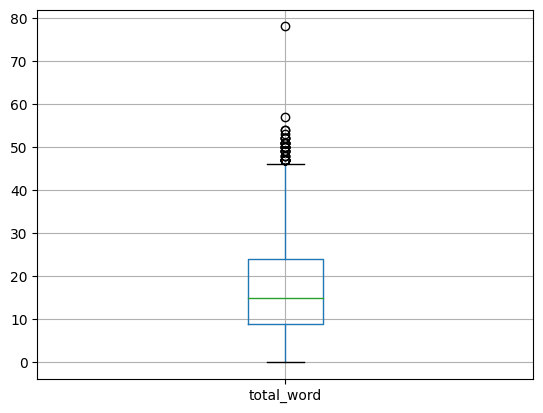

In [90]:
traints.boxplot(column='total_word')
plt.show()

In [91]:
jumlah_outlier = len(outlier)
print(f"Jumlah outlier: {jumlah_outlier}")

Jumlah outlier: 39


In [92]:
#data training no outlier
trainn = traints[(traints['total_word'] >= batas_bawah) & (traints['total_word'] <= batas_atas)]
trainn = trainn.reset_index(drop=True)
trainn.tail()

,Kalimat,Sentiment,Clean,total_char,total_word
10889,f - demokrat dorong upaya kemandirian energi n...,neutral,f demokrat dorong upaya kemandirian energi nas...,51,7
10890,tidak bosan,positive,bosan,5,1
10891,enak rasa masakan nya apalagi kepiting yang me...,positive,enak masakan nya kepiting menyenangkan memilih...,80,11
10892,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi tol pasteur macet parah bikin jengkel,47,8
10893,meskipun sering belanja ke yogya di riau junct...,positive,belanja yogyakarta riau junction kali lihat fo...,196,28


In [93]:
trainn.shape

(10894, 5)

## Neural Network (MLP Classifier)

### Feature Extraction

In [94]:
dataprep = trainn.Clean.to_list()
cv_nn = CountVectorizer()
cv_nn.fit(dataprep)

X = cv_nn.transform(dataprep)
print('Feature Extraction done')
print (X)

Feature Extraction done
  (0, 912)	1
  (0, 1005)	1
  (0, 1155)	1
  (0, 1475)	1
  (0, 1700)	1
  (0, 2085)	1
  (0, 3714)	1
  (0, 3766)	2
  (0, 4053)	1
  (0, 5322)	1
  (0, 5714)	1
  (0, 6248)	1
  (0, 6424)	1
  (0, 7275)	1
  (0, 8340)	1
  (0, 8411)	1
  (0, 9134)	2
  (0, 9165)	1
  (0, 10003)	1
  (0, 10240)	1
  (0, 10927)	1
  (0, 11713)	1
  (0, 11751)	1
  (0, 12786)	1
  (0, 14032)	1
  :	:
  (10893, 905)	1
  (10893, 1160)	1
  (10893, 1215)	1
  (10893, 1371)	1
  (10893, 1472)	1
  (10893, 1854)	1
  (10893, 1986)	1
  (10893, 3990)	1
  (10893, 4723)	1
  (10893, 4724)	1
  (10893, 6167)	1
  (10893, 6263)	1
  (10893, 7352)	1
  (10893, 7680)	1
  (10893, 7818)	1
  (10893, 7971)	1
  (10893, 7972)	2
  (10893, 10003)	3
  (10893, 11338)	1
  (10893, 11339)	1
  (10893, 12133)	1
  (10893, 12169)	1
  (10893, 14569)	1
  (10893, 14723)	1
  (10893, 15439)	1


In [95]:
pickle.dump(cv_nn, open('asset/feature/feature_nn.pickle','wb'))

### Train Model NN

In [96]:
Y = trainn.Sentiment
Y.head()

0    positive
1     neutral
2    positive
3    positive
4    negative
Name: Sentiment, dtype: object

In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [98]:
model_nn = MLPClassifier()
model_nn.fit(X_train, Y_train)

print('Training selesai')

Training selesai


In [99]:
pickle.dump(model_nn, open('asset/model/model_nn.pickle','wb'))

### Evaluation NN

In [100]:
test = model_nn.predict(X_test)

print ('testing selesai')
print(classification_report(Y_test, test))

testing selesai
              precision    recall  f1-score   support

    negative       0.70      0.73      0.72       709
     neutral       0.73      0.54      0.62       225
    positive       0.85      0.87      0.86      1245

    accuracy                           0.79      2179
   macro avg       0.76      0.71      0.73      2179
weighted avg       0.79      0.79      0.79      2179



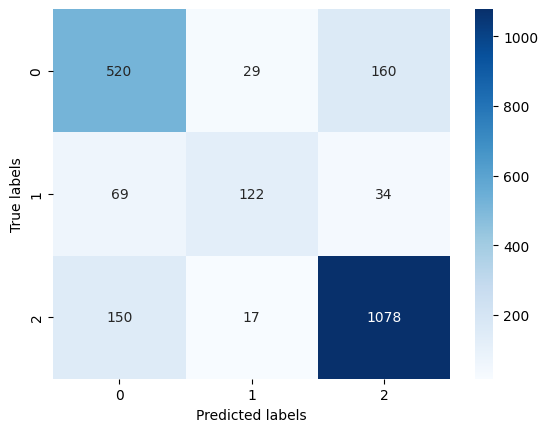

In [101]:
cm_nn = confusion_matrix(Y_test, test)

sns.heatmap(cm_nn, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [102]:
# Create a KFold object with 5 splits and a fixed random state
Kf = KFold(n_splits=5, shuffle=True, random_state=42)
akurasi = []

In [103]:
for iteration, data in enumerate(Kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = Y[data[0]]

    data_test = X[data[1]]
    target_test = Y[data[1]]

    clf = MLPClassifier()
    clf.fit(data_train, target_train)
    
    pred = clf.predict(data_test)
    akrsi = accuracy_score(target_test,pred)

    print("Training ke: ", iteration)
    print("---")
    print(classification_report(target_test,pred))

akurasi.append(akrsi)
print("rata-rata akurasi: ", np.mean(akurasi))

Training ke:  1
---
              precision    recall  f1-score   support

    negative       0.74      0.76      0.75       720
     neutral       0.67      0.57      0.61       214
    positive       0.86      0.87      0.87      1245

    accuracy                           0.80      2179
   macro avg       0.76      0.73      0.74      2179
weighted avg       0.80      0.80      0.80      2179

Training ke:  2
---
              precision    recall  f1-score   support

    negative       0.68      0.74      0.71       679
     neutral       0.72      0.53      0.61       223
    positive       0.86      0.86      0.86      1277

    accuracy                           0.79      2179
   macro avg       0.75      0.71      0.73      2179
weighted avg       0.79      0.79      0.79      2179

Training ke:  3
---
              precision    recall  f1-score   support

    negative       0.68      0.69      0.68       638
     neutral       0.70      0.55      0.62       246
    positive   

### Predict Test NN

In [104]:
ori = '''
selamat makan'''

te = cv_nn.transform([clean(ori)])
res = model_nn.predict(te)[0]

print(ori)
print('sentiment:', res)


selamat makan
sentiment: neutral


## LSTM (Long-short Term Memory)

### Feature Extraction LSTM

In [105]:
neg = trainn.loc[trainn.Sentiment == 'negative'].Clean.tolist()
neu = trainn.loc[trainn.Sentiment == 'neutral'].Clean.tolist()
pos = trainn.loc[trainn.Sentiment == 'positive'].Clean.tolist()

neg_sntmnt = trainn.loc[trainn.Sentiment == 'negative'].Sentiment.tolist()
neu_sntmnt = trainn.loc[trainn.Sentiment == 'neutral'].Sentiment.tolist()
pos_sntmnt = trainn.loc[trainn.Sentiment == 'positive'].Sentiment.tolist()

In [106]:
total_data = pos + neu + neg
labels = pos_sntmnt + neu_sntmnt + neg_sntmnt

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6354, Neu: 1136, Neg: 3404
Total data: 10894


In [127]:
max_features = 50000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('asset/feature/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('asset/feature/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [128]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('asset/feature/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


### Train Model LSTM

In [129]:
file = open("asset/feature/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("asset/feature/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [138]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.002)))
model.add(Dense(3,activation='softmax'))

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 46, 100)           5000000   
                                                                 
 lstm_19 (LSTM)              (None, 128)               117248    
                                                                 
 dense_19 (Dense)            (None, 3)                 387       
                                                                 
Total params: 5,117,635
Trainable params: 5,117,635
Non-trainable params: 0
_________________________________________________________________


c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/50
137/137 [==============================] - 34s 215ms/step - loss: 0.7465 - accuracy: 0.7378 - val_loss: 0.5621 - val_accuracy: 0.7921
Epoch 2/50
137/137 [==============================] - 27s 200ms/step - loss: 0.3856 - accuracy: 0.8709 - val_loss: 0.4432 - val_accuracy: 0.8495
Epoch 3/50
137/137 [==============================] - 29s 213ms/step - loss: 0.2342 - accuracy: 0.9277 - val_loss: 0.5032 - val_accuracy: 0.8320
Epoch 4/50
137/137 [==============================] - 30s 220ms/step - loss: 0.1662 - accuracy: 0.9508 - val_loss: 0.5684 - val_accuracy: 0.8408
Epoch 5/50
137/137 [==============================] - 29s 208ms/step - loss: 0.1236 - accuracy: 0.9631 - val_loss: 0.5660 - val_accuracy: 0.8178
Epoch 6/50
137/137 [==============================] - 30s 219ms/step - loss: 0.1073 - accuracy: 0.9694 - val_loss: 0.7038 - val_accuracy: 0.8031
Epoch 7/50
137/137 [==============================] - 29s 214ms/step - loss: 0.1133 - accuracy: 0.9678 - val_loss: 0.6817 - v

### Evaluation LSTM

In [139]:
predictions = model.predict(X_test)
y_pred = predictions
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(y_test, axis=1)
matrix_test = metrics.classification_report(Y_test_classes, y_pred_classes)
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 2s 16ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       685
           1       0.77      0.56      0.65       235
           2       0.86      0.87      0.87      1259

    accuracy                           0.81      2179
   macro avg       0.78      0.74      0.75      2179
weighted avg       0.81      0.81      0.81      2179



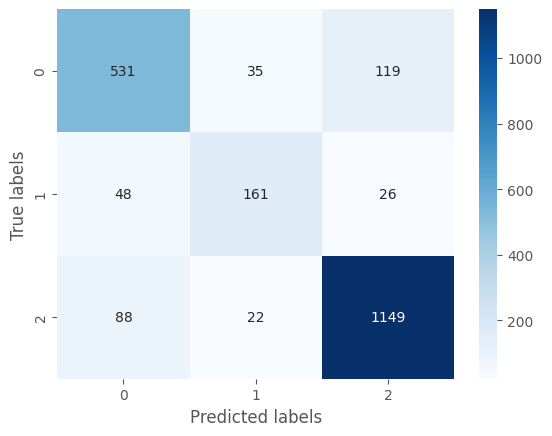

In [132]:
cm_LSTM = confusion_matrix(Y_test_classes, y_pred_classes)

sns.heatmap(cm_LSTM, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [137]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy *100)

c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


KeyboardInterrupt: 

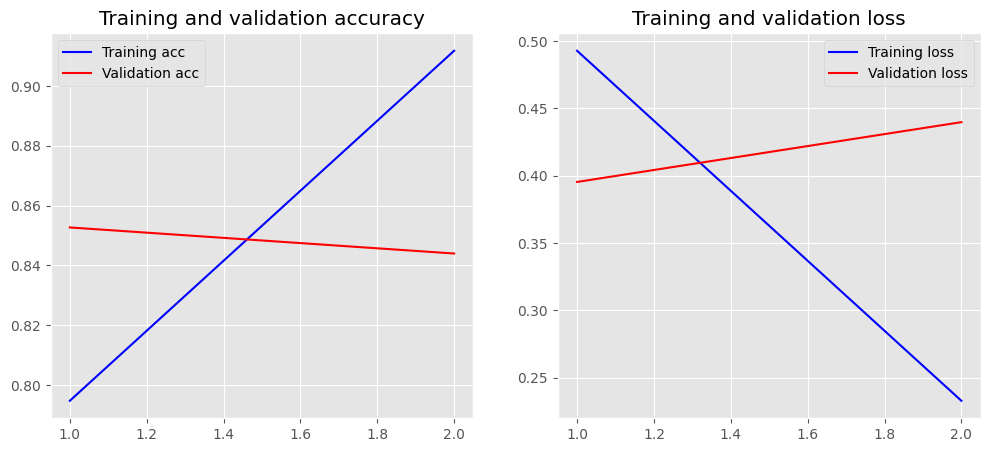

In [134]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [135]:
model.save('asset/model/model_lstm.h5')
print("Model has created!")

Model has created!


### Predict Test LSTM

In [136]:
input_text = """
selamat malam semua"""

sentiment = ['negative', 'neutral', 'positive']

text = [clean(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model_lstm = load_model('asset/model/model_lstm.h5')
prediction = model_lstm.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 1s 1s/step
Text:  selamat malam
Sentiment:  neutral
